In [1]:
import sys
sys.path.append('..')
sys.path.append('../Libraries/')
import pclpy
import ARUSTUFF
import Plane
import Corners
import cv2
import imp
import glob
import os
import numpy as np
import pcl
import open3d
import pdal
from Plane import tic,toc
import segTree
import pandas as pd
from CameraStuff import showim
import CameraStuff
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

WARNING (<module>): Couldn't load netifaces, some utils won't work


In [2]:
def PCLmouseEvent(event):
    global newv
    if not hasattr(PCLmouseEvent, "counter"):
        PCLmouseEvent.counter = 0
    PCLmouseEvent.counter += 1
    if (event.getButton() == pclpy.pcl.visualization.MouseEvent.LeftButton) & (event.getType() == pclpy.pcl.visualization.MouseEvent.MouseButtonRelease):
        newv.addText('thing',event.getX(),event.getY(),'P'+str(PCLmouseEvent.counter))

def PCLKeyboardEvent(event):
    global newv
    global angle
    global ThreshC
    if (event.getKeySym() == 'k') & (event.keyUp()):
        angle -= 1
    if (event.getKeySym() == 'i') & (event.keyUp()):
        angle += 1
    if (event.getKeySym() == 'l') & (event.keyUp()):
        ThreshC -= 0.01
    if (event.getKeySym() == 'o') & (event.keyUp()):
        ThreshC += 0.01
    newv.updateText('angle '+"{:.3f}".format(angle),0,20,20,1.,0.,0.,'angle')
    newv.updateText('ThreshC '+"{:.3f}".format(ThreshC),0,50,20,1.,0.,0.,'ThreshC')
        #newv.addText('thing',event.getX(),event.getY(),'P'+str(PCLmouseEvent.counter))

In [16]:
#Get ground truth
filenumber = 3
print('Get ground truth :',filenumber)
treedata = pd.read_csv('..\..\EuroSDR_DataRelease\EuroSDR_DataRelease/TLS_Benchmarking_Plot_'+str(filenumber)+'_LHD.txt',sep = '\t',names = ['x','y','height','DBH'])
Xcor,Ycor,diam = treedata.iloc[0,[0,1,3]]
surtreesL1 = [Corners.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20)]
Zcor = 0
TreeDict = [np.array([Xcor,Ycor,diam])]
for i,rows in treedata.iloc[1:].iterrows():
    Xcor,Ycor,diam = rows.iloc[[0,1,3]]
    if not np.any(np.isnan([Xcor,Ycor,diam])):
        surtreesL1.append(Corners.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=5,dense=80))
        TreeDict.append(np.array([Xcor,Ycor,diam]))
surtrees1 = [p for i in surtreesL1 for p in i]
surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)

NongroundCloud = pclpy.pcl.PointCloud.PointXYZ()
pclpy.pcl.io.loadPCDFile('Clouds/AllNonGroundEuroLESS'+str(filenumber)+'.pcd',NongroundCloud)

groundCloud = pclpy.pcl.PointCloud.PointXYZ()
pclpy.pcl.io.loadPCDFile('Clouds/AllGroundEuroLESS'+str(filenumber)+'.pcd',groundCloud)

puntosnp = NongroundCloud.xyz

Get ground truth : 3


In [17]:
if False:
    individualTree = []
    for i in TreeDict:
        x,y,d = i
        scale = 3
        x1,y1,z1 = x-d*scale,y-d*scale,-50
        x2,y2,z2 = x+d*scale,y+d*scale,50
        ptfilter = pclpy.pcl.filters.CropBox.PointXYZ()
        ptfilter.setInputCloud(NongroundCloud)
        ptfilter.setMin([x1,y1,z1,0])
        ptfilter.setMax([x2,y2,z2,0])
        Cropedmm11 = pclpy.pcl.PointCloud.PointXYZ()
        ptfilter.filter(Cropedmm11)
        individualTree.append(Cropedmm11)

    Corners.PCL3dpaint(individualTree)

    sortedPC = sorted(Cropedmm11.xyz.tolist(),key= lambda x:[x[2],x[0],x[1]])

In [4]:
NongroundCloud = pclpy.pcl.PointCloud.PointXYZ()
pclpy.pcl.io.loadPCDFile('../../Data/NistClouds/AllNonGround.pcd',NongroundCloud)

puntosnp = NongroundCloud.xyz

In [8]:
normals = segTree.ExtractNormals(puntosnp,0.2)
#Corners.PCL3dpaint([puntosnp,puntosnp+normals.normals*0.1,puntosnp+normals.normals*0.2])

In [9]:
angle = 50
ThreshV = np.cos(np.deg2rad(angle))
ThreshC = 0.15

nanmask = np.bitwise_not(np.isnan(normals.normals[:,0]))
NonNANpoints = NongroundCloud.xyz[nanmask]
NonNANnormals = normals.normals[nanmask]
NonNANcurvature = normals.curvature[nanmask]
verticality = np.dot(NonNANnormals,[[0],[0],[1]])
mask = (verticality < ThreshV) & (-ThreshV < verticality)  #0.1
maskC = (NonNANcurvature < ThreshC)## 0.12
Fmask = mask.ravel() & maskC.ravel()

onlyhorizontalpointsOr = NonNANpoints[Fmask]
onlyhorizontalnormalsOr = NonNANnormals[Fmask]

In [16]:
if True:
    try:
        newv = pclpy.pcl.visualization.PCLVisualizer()
        #newv.registerMouseCallback(PCLmouseEvent)
        newv.registerKeyboardCallback(PCLKeyboardEvent)
        newv.addText('angle '+"{:.3f}".format(angle),0,20,20,1.,0.,0.,'angle')
        newv.addText('ThreshC '+"{:.3f}".format(ThreshC),0,50,20,1.,0.,0.,'ThreshC')
        while not newv.wasStopped():
            verticality = np.dot(NonNANnormals,[[0],[0],[1]])
            mask = (verticality < ThreshV) & (-ThreshV < verticality)  #0.1
            maskC = (NonNANcurvature < ThreshC)## 0.12
            Fmask = mask.ravel() & maskC.ravel()

            onlyhorizontalpoints = NonNANpoints[Fmask]
            pointcloud = pclpy.pcl.PointCloud.PointXYZ(onlyhorizontalpoints)
            newv.removeAllPointClouds()
            colorHandeler = pclpy.pcl.visualization.PointCloudColorHandlerCustom.PointXYZ(pointcloud,0,150,0)
            newv.addPointCloud(pointcloud,colorHandeler,'PC')
            
            newv.spinOnce(200)
            ThreshV = np.cos(np.deg2rad(angle))
        newv.close()

    except Exception as e:
        newv.close()
        print(e)

In [17]:
ThreshV

0.052335956242943966

In [15]:
angle = 60
ThreshV = np.cos(np.deg2rad(angle))
ThreshC = 0.1

nanmask = np.bitwise_not(np.isnan(normals.normals[:,0]))
NonNANpoints = NongroundCloud.xyz[nanmask]
NonNANnormals = normals.normals[nanmask]
NonNANcurvature = normals.curvature[nanmask]
verticality = np.dot(NonNANnormals,[[0],[0],[1]])
mask = (verticality < ThreshV) & (-ThreshV < verticality)  #0.1
maskC = (NonNANcurvature < ThreshC)## 0.12
Fmask = mask.ravel() & maskC.ravel()

onlyhorizontalpoints = NonNANpoints[Fmask]
onlyhorizontalnormals = NonNANnormals[Fmask]

In [21]:
pointpart = groundCloud.xyz
A = np.c_[np.ones(pointpart.shape[0]), pointpart[:,:2], np.prod(pointpart[:,:2], axis=1), pointpart[:,:2]**2]
C,_,_,_ = np.linalg.lstsq(A, pointpart[:,2])
X = onlyhorizontalpoints[:,0]
Y = onlyhorizontalpoints[:,1]
Z = np.dot(np.c_[np.ones(X.shape), X, Y, X*Y, X**2, Y**2], C)

C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
onlyhorizontalpointsNorm = onlyhorizontalpoints[onlyhorizontalpoints[:,2]<2-Z]

scalefactor = 20
traslation = np.min(onlyhorizontalpointsNorm,axis = 0)*scalefactor
W,H,_ = np.ceil(np.max(onlyhorizontalpointsNorm,axis = 0)-np.min(onlyhorizontalpointsNorm,axis = 0))+1
depth = np.zeros([int(W*scalefactor),int(H*scalefactor)],dtype = np.uint16)
intpoints = np.round((onlyhorizontalpointsNorm-np.min(onlyhorizontalpointsNorm,axis = 0))*scalefactor).astype(np.int)

(unique, counts) = np.unique(intpoints[:,0:2],axis=0, return_counts=True)
depth = np.zeros([int(W*scalefactor),int(H*scalefactor)],dtype = np.uint16)
depth[unique[:,0],unique[:,1]] = counts

threshhold = 20
normdepth = cv2.normalize(depth,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U)
_,normdepth = cv2.threshold(normdepth,threshhold,255,cv2.THRESH_BINARY)

treeLOC = np.zeros([int(W*scalefactor),int(H*scalefactor),3],dtype = np.uint8)
for i in TreeDict:
    cv2.circle(treeLOC,(int(i[1]*scalefactor-traslation[1]),int(i[0]*scalefactor-traslation[0])),int(i[2]*scalefactor),(0,0,255),2)

withthresh = CameraStuff.GRAY3Channels(normdepth) + treeLOC
CameraStuff.showim(withthresh)

In [28]:
def detectblobs(img1):
    #Preparar detector de blob
    params = cv2.SimpleBlobDetector_Params()
    params.minThreshold = 10
    params.maxThreshold = 256
    params.filterByArea = True
    params.minArea = 1
    params.maxArea = 6000
    params.filterByCircularity = False
    params.minCircularity = 0.1
    params.filterByConvexity = False
    params.minConvexity = 0.87
    params.filterByInertia = False
    params.minInertiaRatio = 0.01
    detector = cv2.SimpleBlobDetector_create(params)
    #Debug()
    #Detectar Blobs
    gimg1 = cv2.bitwise_not(img1)
    keypoints1 = detector.detect(gimg1)

    return keypoints1

In [29]:
cloesed = cv2.morphologyEx(normdepth,cv2.MORPH_CLOSE,np.ones([5,5]),iterations=3)
blobs = detectblobs(cloesed)
buf = CameraStuff.GRAY3Channels(cloesed).copy()
for i in blobs:
    cv2.circle(buf,(int(i.pt[0]),int(i.pt[1])),int(i.size/2),(0,255,0),1)
CameraStuff.showim(buf)

trees = []
ptfilter = pclpy.pcl.filters.CropBox.PointXYZ()
onlyhorizontalPC = pclpy.pcl.PointCloud.PointXYZ(onlyhorizontalpointsNorm)
ptfilter.setInputCloud(onlyhorizontalPC)
Cropedmm11 = pclpy.pcl.PointCloud.PointXYZ()
for i in blobs:
    y,x = (i.pt[0]+traslation[0])/scalefactor,(i.pt[1]+traslation[1])/scalefactor
    d = i.size/scalefactor
    scale = 4
    x1,y1,z1 = x-d*scale,y-d*scale,-50
    x2,y2,z2 = x+d*scale,y+d*scale,50
    ptfilter.setMin([x1,y1,z1,0])
    ptfilter.setMax([x2,y2,z2,0])
    ptfilter.filter(Cropedmm11)
    trees.append(Cropedmm11.xyz)

finalstems = []
stemcyls = []
rech = []
for p in trees:
    segpoints = p
    indices, model = segTree.segment_normals(segpoints, searchRadius=0.1, model=pcl.SACMODEL_CYLINDER, method=pcl.SAC_RANSAC, normalweight=0.01, miter=10000, distance=0.08, rlim=[0,0.4])
    if len(indices)>0:
        if abs(np.dot(model[3:6],[0,0,1])/np.linalg.norm(model[3:6])) > 0.5:
            newmodel = model
            Z = 1.3 + p[1][2]
            Y = model[1] + model[4] * (Z - model[2]) / model[5]
            X = model[0] + model[3] * (Z - model[2]) / model[5]
            newmodel[0:3] = np.array([X,Y,Z])
            newmodel[3:6] = Plane.similarize(newmodel[3:6],[0,0,1])
            finalstems.append({'tree':segpoints[indices],'model':newmodel})
            stemcyls.append(Corners.makecylinder(model=newmodel,length=3,dense=20))
        else:
            rech.append(segpoints)
    else:
        rech.append(segpoints)

In [28]:
Corners.PCL3dpaint([[p*0.97 for i in surtreesL1 for p in i],[p*0.99 for i in trees for p in i],[p for i in stemcyls for p in i]])

In [32]:
scalefactor = 20
traslation = np.min(onlyhorizontalpointsNorm,axis = 0)*scalefactor
W,H,_ = np.ceil(np.max(onlyhorizontalpointsNorm,axis = 0)-np.min(onlyhorizontalpointsNorm,axis = 0))+1
treeLOC = np.zeros([int(W*scalefactor),int(H*scalefactor),3],dtype = np.uint8)
for i in TreeDict:
    #cv2.circle(treeLOC,(int(i[1]*scalefactor-traslation[1]),int(i[0]*scalefactor-traslation[0])),min(int(i[2]*scalefactor*10),20),(0,0,255),2)
    cv2.circle(treeLOC,(int(i[1]*scalefactor-traslation[1]),int(i[0]*scalefactor-traslation[0])),5,(0,0,255),2)

intpoints = np.round((onlyhorizontalpointsNorm-np.min(onlyhorizontalpointsNorm,axis = 0))*scalefactor).astype(np.int)

(unique, counts) = np.unique(intpoints[:,0:2],axis=0, return_counts=True)

depth = np.zeros([int(W*scalefactor),int(H*scalefactor)],dtype = np.uint16)

depth[unique[:,0],unique[:,1]] = counts

mygui = CameraStuff.AutoGui(variables = ['thresh'],
                            initialvalues=[10],maxvalues=[100])
while True:
    thresh1 = mygui.getbars()
    thresh1 = thresh1[0] + 1
    normdepth = cv2.normalize(depth,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U)
    _,normdepth = cv2.threshold(normdepth,thresh1,255,cv2.THRESH_BINARY)
    normdepth = CameraStuff.GRAY3Channels(normdepth) + treeLOC
    k = CameraStuff.showimKey(normdepth,timing = 10)
    if k == ord('q'):
        break
cv2.destroyAllWindows()

In [36]:
cv2.destroyAllWindows()

In [7]:
Completeness = []
Correctness = []
Mean_AoD = []
Diameter_RMSE = []
Diameter_bias = []
Location_RMSE = []
Location_bias = []

Relative_Diameter_RMSE = []
Relative_Diameter_bias = []
Relative_Location_RMSE = []
Relative_Location_bias = []

n_ref = []
n_match = []
n_extr = []
location_y = []
diameter_y = []
filenumber = 4
for filenumber in range(1,7):
    #Load info
    print('Load info :',filenumber)
    NongroundCloud = pclpy.pcl.PointCloud.PointXYZ()
    pclpy.pcl.io.loadPCDFile('Clouds/AllNonGroundEuroLESS'+str(filenumber)+'.pcd',NongroundCloud)
    
    groundCloud = pclpy.pcl.PointCloud.PointXYZ()
    pclpy.pcl.io.loadPCDFile('Clouds/AllGroundEuroLESS'+str(filenumber)+'.pcd',groundCloud)


    #getnormals
    normals = segTree.ExtractNormals(NongroundCloud.xyz)

    #Corners.PCL3dpaint([NongroundCloud.xyz,NongroundCloud.xyz+normals.normals*0.1,NongroundCloud.xyz+normals.normals*0.2])

    #Get ground truth
    print('Get ground truth :',filenumber)
    treedata = pd.read_csv('..\..\EuroSDR_DataRelease\EuroSDR_DataRelease/TLS_Benchmarking_Plot_'+str(filenumber)+'_LHD.txt',sep = '\t',names = ['x','y','height','DBH'])
    Xcor,Ycor,diam = treedata.iloc[0,[0,1,3]]
    surtreesL1 = [Corners.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20)]
    Zcor = 0
    TreeDict = [np.array([Xcor,Ycor,diam])]
    for i,rows in treedata.iloc[1:].iterrows():
        Xcor,Ycor,diam = rows.iloc[[0,1,3]]
        if not np.any(np.isnan([Xcor,Ycor,diam])):
            surtreesL1.append(Corners.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20))
            TreeDict.append(np.array([Xcor,Ycor,diam]))
    surtrees1 = [p for i in surtreesL1 for p in i]
    surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)
    
    angle = 80
    ThreshV = np.cos(np.deg2rad(angle))
    ThreshC = 0.06

    nanmask = np.bitwise_not(np.isnan(normals.normals[:,0]))
    NonNANpoints = NongroundCloud.xyz[nanmask]
    NonNANnormals = normals.normals[nanmask]
    NonNANcurvature = normals.curvature[nanmask]
    verticality = np.dot(NonNANnormals,[[0],[0],[1]])
    mask = (verticality < ThreshV) & (-ThreshV < verticality)  #0.1
    maskC = (NonNANcurvature < ThreshC)## 0.12
    Fmask = mask.ravel() & maskC.ravel()

    onlyhorizontalpoints = NonNANpoints[Fmask]
    onlyhorizontalnormals = NonNANnormals[Fmask]

    
    pointpart = groundCloud.xyz
    A = np.c_[np.ones(pointpart.shape[0]), pointpart[:,:2], np.prod(pointpart[:,:2], axis=1), pointpart[:,:2]**2]
    C,_,_,_ = np.linalg.lstsq(A, pointpart[:,2])
    X = onlyhorizontalpoints[:,0]
    Y = onlyhorizontalpoints[:,1]
    Z = np.dot(np.c_[np.ones(X.shape), X, Y, X*Y, X**2, Y**2], C)
    #Corners.PCL3dpaint([onlyhorizontalpoints,onlyhorizontalpoints+onlyhorizontalnormals*0.05,onlyhorizontalpoints+onlyhorizontalnormals*0.1])

    onlyhorizontalpointsNorm = onlyhorizontalpoints[onlyhorizontalpoints[:,2]<2-Z]

    scalefactor = 20
    traslation = np.min(onlyhorizontalpointsNorm,axis = 0)*scalefactor
    W,H,_ = np.ceil(np.max(onlyhorizontalpointsNorm,axis = 0)-np.min(onlyhorizontalpointsNorm,axis = 0))+1
    depth = np.zeros([int(W*scalefactor),int(H*scalefactor)],dtype = np.uint16)
    intpoints = np.round((onlyhorizontalpointsNorm-np.min(onlyhorizontalpointsNorm,axis = 0))*scalefactor).astype(np.int)

    (unique, counts) = np.unique(intpoints[:,0:2],axis=0, return_counts=True)
    depth = np.zeros([int(W*scalefactor),int(H*scalefactor)],dtype = np.uint16)
    depth[unique[:,0],unique[:,1]] = counts

    threshhold = 20
    normdepth = cv2.normalize(depth,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U)
    _,normdepth = cv2.threshold(normdepth,threshhold,255,cv2.THRESH_BINARY)

    treeLOC = np.zeros([int(W*scalefactor),int(H*scalefactor),3],dtype = np.uint8)
    for i in TreeDict:
        cv2.circle(treeLOC,(int(i[1]*scalefactor-traslation[1]),int(i[0]*scalefactor-traslation[0])),int(i[2]*scalefactor),(0,0,255),2)

    withthresh = CameraStuff.GRAY3Channels(normdepth) + treeLOC

    cloesed = cv2.morphologyEx(normdepth,cv2.MORPH_CLOSE,np.ones([3,3]),iterations=3)
    blobs = detectblobs(cloesed)
    buf = CameraStuff.GRAY3Channels(cloesed).copy()
    for i in blobs:
        cv2.circle(buf,(int(i.pt[0]),int(i.pt[1])),int(i.size/2),(0,255,0),1)

    trees = []
    ptfilter = pclpy.pcl.filters.CropBox.PointXYZ()
    onlyhorizontalPC = pclpy.pcl.PointCloud.PointXYZ(onlyhorizontalpointsNorm)
    ptfilter.setInputCloud(onlyhorizontalPC)
    Cropedmm11 = pclpy.pcl.PointCloud.PointXYZ()
    for i in blobs:
        y,x = (i.pt[0]+traslation[0])/scalefactor,(i.pt[1]+traslation[1])/scalefactor
        d = i.size/scalefactor
        scale = 4
        x1,y1,z1 = x-d*scale,y-d*scale,-50
        x2,y2,z2 = x+d*scale,y+d*scale,50
        ptfilter.setMin([x1,y1,z1,0])
        ptfilter.setMax([x2,y2,z2,0])
        ptfilter.filter(Cropedmm11)
        trees.append(Cropedmm11.xyz)

    finalstems = []
    stemcyls = []
    rech = []
    for p in trees:
        segpoints = p
        indices, model = segTree.segment_normals(segpoints, searchRadius=0.1, model=pcl.SACMODEL_CYLINDER, method=pcl.SAC_RANSAC, normalweight=0.01, miter=10000, distance=0.08, rlim=[0,0.4])
        if len(indices)>0:
            if abs(np.dot(model[3:6],[0,0,1])/np.linalg.norm(model[3:6])) > 0.5:
                newmodel = model
                Z = 1.3 + p[1][2]
                Y = model[1] + model[4] * (Z - model[2]) / model[5]
                X = model[0] + model[3] * (Z - model[2]) / model[5]
                newmodel[0:3] = np.array([X,Y,Z])
                newmodel[3:6] = Plane.similarize(newmodel[3:6],[0,0,1])
                finalstems.append({'tree':segpoints[indices],'model':newmodel})
                stemcyls.append(Corners.makecylinder(model=newmodel,length=3,dense=20))
            else:
                rech.append(segpoints)
        else:
            rech.append(segpoints)

            
    #####################################################


                #DataBase
    #Found trees
    #Hungarian Algorithm assignment
    print('Hungarian Algorithm assignment :',filenumber)
    CostMat = np.ones([len(TreeDict),len(stemcyls)])
    for X,datatree in enumerate(TreeDict):
        for Y,foundtree in enumerate(finalstems):
            CostMat[X,Y] = np.linalg.norm([datatree[0:2]-foundtree['model'][0:2]])

    dataindex, foundindex = linear_sum_assignment(CostMat,maximize=False)

    #Get metrics
    print('Get metrics: ',filenumber)
    locationerror = []
    correctlocationerror = []
    diametererror = []
    cloudmatch = []
    for i,j in zip(dataindex, foundindex):
        locationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
        if locationerror[-1]<0.4:
            diametererror.append(abs(finalstems[j]['model'][6]*2-TreeDict[i][2]))        
            correctlocationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
        cloudmatch.append(np.vstack([surtreesL1[i],finalstems[j]['tree'],stemcyls[j]]))


    n_ref.append(len(TreeDict))
    n_match.append(len(diametererror))
    n_extr.append(len(locationerror) - n_match[-1])
    location_y.append(np.linalg.norm(np.sum(np.array([TreeDict[i][0:2] for i in dataindex]),axis=0)/len(dataindex)))
    diameter_y.append(np.sum(np.array([finalstems[i]['model'][6]*2 for i in foundindex]),axis=0)/len(foundindex))

    Completeness.append(n_match[-1]/n_ref[-1])
    Correctness.append(n_match[-1]/(n_extr[-1]+n_match[-1]))
    Mean_AoD.append(2*n_match[-1]/(n_ref[-1]+n_extr[-1]))
    Diameter_RMSE.append(np.sqrt(np.sum(np.array(diametererror)**2)/len(diametererror)))
    Diameter_bias.append(np.sum(np.array(diametererror))/len(diametererror))
    Location_RMSE.append(np.sqrt(np.sum(np.array(correctlocationerror)**2)/len(correctlocationerror)))
    Location_bias.append(np.sum(np.array(correctlocationerror))/len(correctlocationerror))

    Relative_Diameter_RMSE.append(Diameter_RMSE[-1]/diameter_y[-1])
    Relative_Diameter_bias.append(Diameter_bias[-1]/diameter_y[-1])
    Relative_Location_RMSE.append(Location_RMSE[-1]/location_y[-1])
    Relative_Location_bias.append(Location_bias[-1]/location_y[-1])

Load info : 1
Get ground truth : 1


C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:69: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Hungarian Algorithm assignment : 1
Get metrics:  1
Load info : 2
Get ground truth : 2
Hungarian Algorithm assignment : 2
Get metrics:  2
Load info : 3
Get ground truth : 3
Hungarian Algorithm assignment : 3
Get metrics:  3
Load info : 4
Get ground truth : 4
Hungarian Algorithm assignment : 4
Get metrics:  4
Load info : 5
Get ground truth : 5
Hungarian Algorithm assignment : 5
Get metrics:  5
Load info : 6
Get ground truth : 6
Hungarian Algorithm assignment : 6
Get metrics:  6


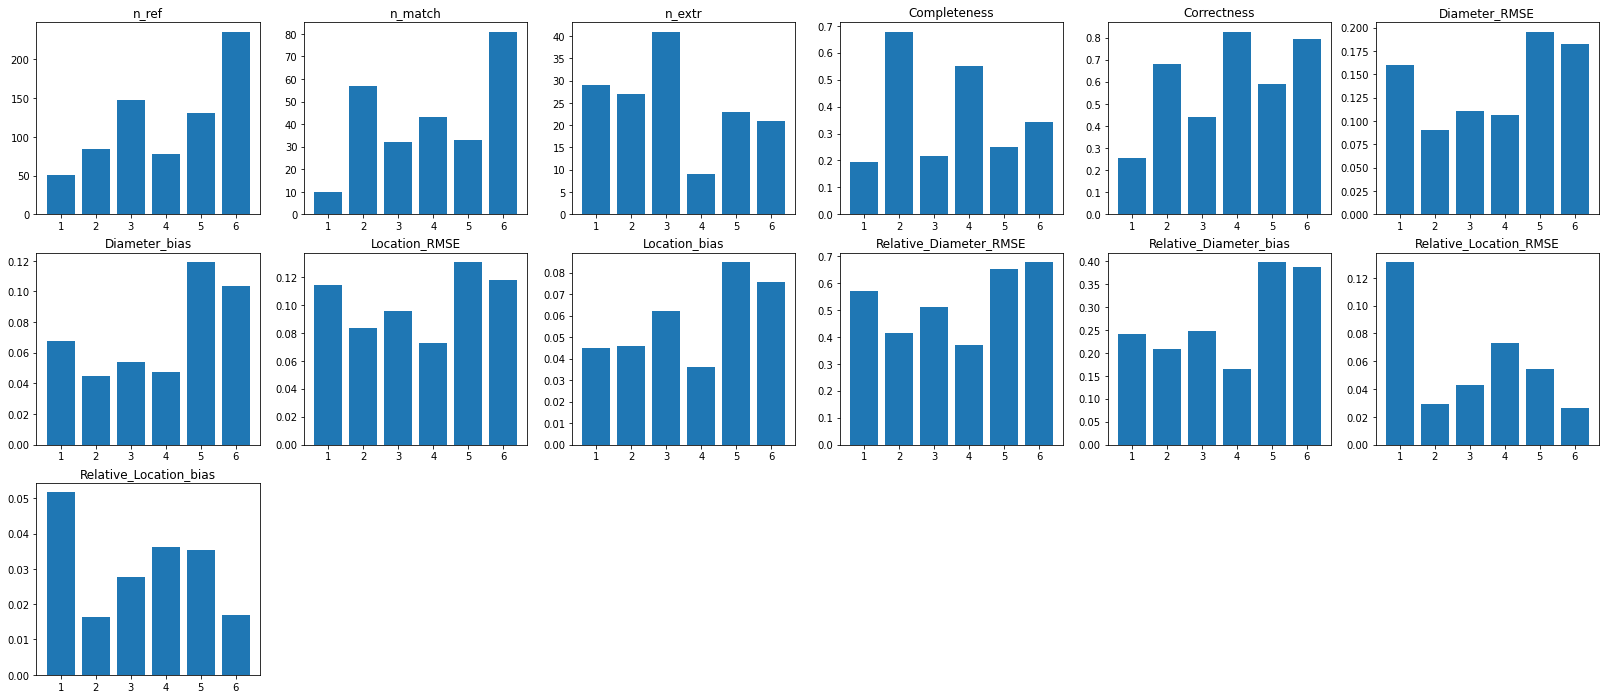

In [8]:
alldata = ['n_ref', 'n_match', 'n_extr', 'Completeness', 'Correctness', 'Diameter_RMSE', 'Diameter_bias', 
           'Location_RMSE', 'Location_bias', 'Relative_Diameter_RMSE', 'Relative_Diameter_bias', 'Relative_Location_RMSE', 'Relative_Location_bias']
plt.figure(figsize=(28,12))
for n,i in enumerate(alldata):
    plt.subplot(3,6,n+1)
    plt.title(i)
    plt.bar(np.array([1,2,3,4,5,6]),eval(i))